# Camera intrinsics, screen coordinates and 3D data.

First, we install `synthesisai` and download test datasets.

In [ ]:
%%bash
python -m pip install synthesisai
curl https://synthesisai-example-datasets.s3.amazonaws.com/humans_api_example_dataset.zip -o humans_api_example_dataset.zip
unzip humans_api_example_dataset.zip -d humans_api_example_dataset

Now we add some imports for the visualisation.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import cv2
import numpy as np

We use `SaiDataset` class to access synthesis datasets.


In [3]:
from synthesisai import SaiDataset, Modality

In [4]:
data_root = "humans_api_example_dataset"
dataset = SaiDataset(
    data_root,
    modalities=[
        Modality.RGB,
        Modality.CAM_INTRINSICS,
        Modality.LANDMARKS_3D_IBUG68,
        Modality.LANDMARKS_IBUG68,
        Modality.DEPTH,
        Modality.LANDMARKS_3D_MEDIAPIPE_FACE,
        Modality.LANDMARKS_3D_SAI
    ]
)
len(dataset)

114

There are 114 items in the test dataset. Let's explore them closer.

In [5]:
item = dataset[0]

Each item is a dict with different modalities as keys.

In [6]:
print(item.keys())

dict_keys([<Modality.RGB: 2>, <Modality.DEPTH: 4>, <Modality.LANDMARKS_IBUG68: 8>, <Modality.LANDMARKS_3D_IBUG68: 14>, <Modality.CAM_INTRINSICS: 34>, <Modality.LANDMARKS_3D_MEDIAPIPE_FACE: 37>, <Modality.LANDMARKS_3D_SAI: 38>])


In this notebook we explore camera intrinsics and transistion between 3D and the screen coordinate systems.

In [7]:
intrinsics = item[Modality.CAM_INTRINSICS]
intrinsics

array([[3.1030303e+03, 0.0000000e+00, 5.1200000e+02],
       [0.0000000e+00, 3.1030303e+03, 5.1200000e+02],
       [0.0000000e+00, 0.0000000e+00, 1.0000000e+00]])

The camera intrinsics are in OpenCV format:
$$\left [ \begin{matrix} f_x & 0 & c_x \\ 0 & f_y & c_y \\ 0 & 0 & 1 \end{matrix} \right ]$$,
where $f_x$ and $f_y$ are focal distances and $c_x$ and $c_y$ is an optical center
(2D coordinates of the point, camera is pointing at on the image).

Note, that units of distance in 3D are meters and units in 2D are pixels, the conversion coefficient is already included in $f_x$.

$c_x$ and $c_y$ are usually equal to the half of the image resolution as camera is normally pointing to the center of the image.

In [8]:
np.array(item[Modality.RGB].shape[:2]) / 2

array([512., 512.])

Now we can convert between camera and screen coordinate systems. Let's see how it is done, using ibug68 landmarks.

In [10]:
# there is only 1 human in this example, which has an instance id of human_1
human_instance_id = "human_1"
landmark_0 = item[Modality.LANDMARKS_3D_IBUG68][human_instance_id][0]
landmark_0

(-0.0750153586268425, -0.002459546085447073, -1.041256308555603)

At first, we need to check that landmark is in front of the camera (z coordinate is negative):

In [11]:
landmark_0[2] < 0


True

Now we can convert to screen coordinate system, using intrinsic matrix. However, our 3D camera coordinate system uses OpenGL axis (x right, y top, z towards the camera), and OpenCV system uses a different [one](https://docs.opencv.org/4.5.3/d9/d0c/group__calib3d.html) (x right, y bottom, z from the camera).
Thus before we apply the conversion, we need to convert between this coordinate systems, otherwise screen coordinates will be mirrored vertically.

In [12]:
def opengl_to_opencv(x):
    return np.array(x) * [1, -1, -1]

To compute landmark in screen coordinates we need to multiply 3D coordinates by the intrinsic matrix.

In [13]:
def cam_to_hom_screen(intrinsics, x):
    return np.tensordot(opengl_to_opencv(x), intrinsics, axes=(-1, 1))

In [14]:
cam_to_hom_screen(intrinsics, landmark_0)

array([300.34829897, 540.75527602,   1.04125631])

We get the result, but it is in homogeneous coordinates. We need to convert it to euclidian.

In [15]:
def from_homogeneous_2D(xs):
    xs_array = np.array(xs)
    assert (xs_array.shape[-1] == 3)

    slice_but_last = [slice(None)] * (xs_array.ndim - 1) + [slice(None, -1)]
    slice_but_last = tuple(slice_but_last)

    slice_last = [slice(None)] * (xs_array.ndim - 1) + [slice(-1, None)]
    slice_last = tuple(slice_last)
    return xs_array[slice_but_last] / xs_array[slice_last]

In [16]:
def cam_to_screen(intrinsics, x):
    return from_homogeneous_2D(cam_to_hom_screen(intrinsics, x))


In [17]:
cam_to_screen(intrinsics, landmark_0)

array([288.44799931, 519.32965166])

To check ourselves, let's compare with 2D location of this landmark we get from the info.json:

In [18]:
item[Modality.LANDMARKS_IBUG68][human_instance_id][0]

(288.4608, 519.3728)

Now let's have a look, how landmarks look in 3D.

We use ploply to visualise 3D data.

In [19]:
import plotly.express as px
import plotly.graph_objects as go

import pandas as pd

In [20]:
x, y, z =  np.array(list(item[Modality.LANDMARKS_3D_IBUG68][human_instance_id].values()), dtype=np.float64).transpose()
lid = list(item[Modality.LANDMARKS_3D_IBUG68][human_instance_id].keys())

Let's visualize landmarks with labels:

In [ ]:
fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z, text=lid, mode='markers+text', marker={"size": 2})])
fig.update_layout(scene_camera={"eye": {"x": 0., "y": 0., "z": 2},
                                "up": {"x": 0, "y": 1, "z": 0}}, title="iBUG68 3D labeled")
fig.show()

And without them for more clarity:

In [ ]:
fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z, mode='markers+text', marker={"size": 2})])
fig.update_layout(scene_camera={"eye": {"x": 0., "y": 0., "z": 2},
                                "up": {"x": 0, "y": 1, "z": 0}}, title="iBUG68 3D")
fig.show()

Now we can project all the landmarks to the screen and check that the position is correct on the image as well:

In [21]:
import matplotlib.pyplot as plt

In [22]:
def landmark_show(img, landmarks, radius=2, labels=True):
    l_img = np.copy(img)
    for x, y in landmarks:
        int_p = (int(x), int(y))
        cv2.circle(l_img, int_p, radius=radius, color=(255, 0, 0), thickness=cv2.FILLED)
    plt.imshow(l_img)

In [23]:
item = dataset[18]
landmarks_2D = cam_to_screen(intrinsics, np.array(list(item[Modality.LANDMARKS_3D_IBUG68][human_instance_id].values()), dtype=np.float64))

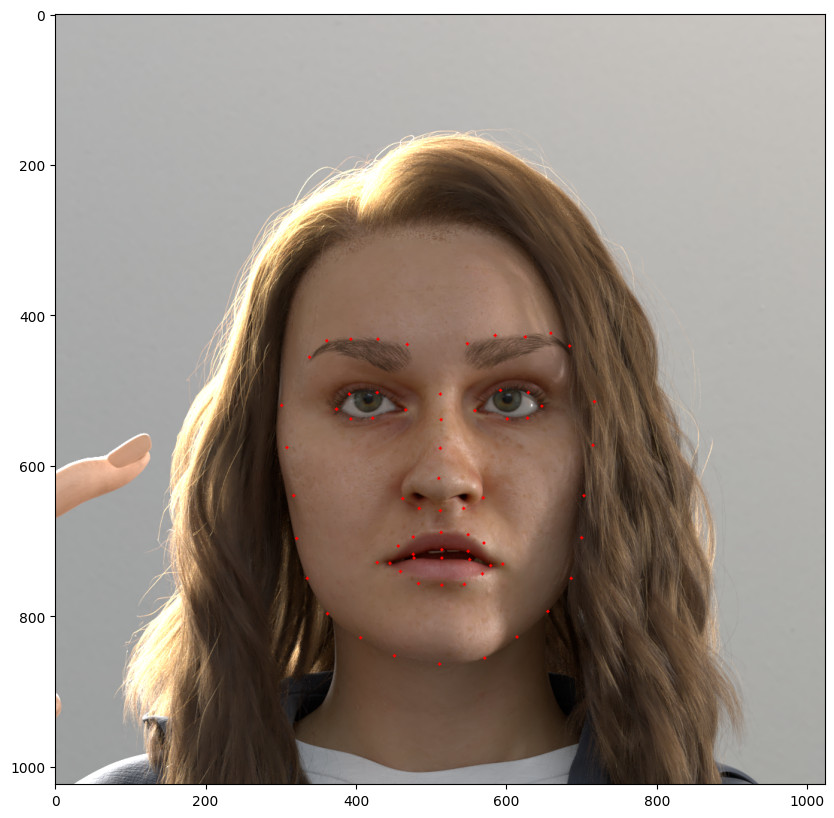

In [24]:
plt.figure(figsize=(10,10))
landmark_show(item[Modality.RGB], landmarks_2D)

From intrinsic transform we can compute reverse intrinsic transform, which is needed to map points from the image to 3D space.

In [25]:
rev_intrinsics = np.linalg.inv(intrinsics)

Screen coordinates are equivealent to the pixel position:

In [26]:
shape = item[Modality.RGB].shape
screen_xs, screen_ys = np.meshgrid(np.linspace(0, shape[1] - 1, shape[1]),
                                   np.linspace(0, shape[0] - 1, shape[0]))
depth = item[Modality.DEPTH]
color = item[Modality.RGB]

To apply reverse projection we need to homogenize the coordinates and multiply them by reversed intrinsic matrix:

In [27]:
xs, ys, zs = np.moveaxis(np.tensordot(np.stack([screen_xs * depth, screen_ys * depth, depth]), rev_intrinsics, axes=(0, 1)), -1, 0) * np.array([1,-1,-1]).reshape(-1, 1, 1)

Now we can show point cloud of the head.

In [ ]:
fig = go.Figure(data=[go.Scatter3d(x=xs[zs<0], y=ys[zs<0], z=zs[zs<0],
                                   mode='markers+text', marker={"size": 1, "color": color[zs<0]})])
fig.update_layout(scene_camera={"eye": {"x": 0., "y": 0., "z": 2},
                                "up": {"x": 0, "y": 1, "z": 0}}, title="Head 3D reconstruction")
fig.show()


To check that everything is correct let's display landmarks at the same 3D plot as well:

In [ ]:
x, y, z =  np.array(list(item[Modality.LANDMARKS_3D_IBUG68][human_instance_id].values()), dtype=np.float64).transpose()

fig = go.Figure(data=[go.Scatter3d(x=xs[zs<0], y=ys[zs<0], z=zs[zs<0],
                                   mode='markers+text', marker={"size": 1, "color": color[zs<0]}),
                      go.Scatter3d(x=x, y=y, z=z, mode='markers+text', marker={"size": 3})])
fig.update_layout(scene_camera={"eye": {"x": 0., "y": 0., "z": 2},
                                "up": {"x": 0, "y": 1, "z": 0}}, title="Head 3D reconstruction with landmarks",
                  showlegend=False)
fig.show()


Let't consider dense landmarks. There are 2 types of them: Modality.LANDMARKS_DENSE_MEDIAPIPE, Modality.LANDMARKS_DENSE_SAI.

In [28]:
lm_dense_mediapipe = item[Modality.LANDMARKS_3D_MEDIAPIPE_FACE][human_instance_id]
lm_dense_sai = item[Modality.LANDMARKS_3D_SAI][human_instance_id]
print(f"Shapes are: {lm_dense_mediapipe.shape} and {lm_dense_sai.shape}")

Shapes are: (468, 3) and (4840, 3)


Both types are in the camera coordinate system, so we can draw them as previous 3d_IBUG landmarks.


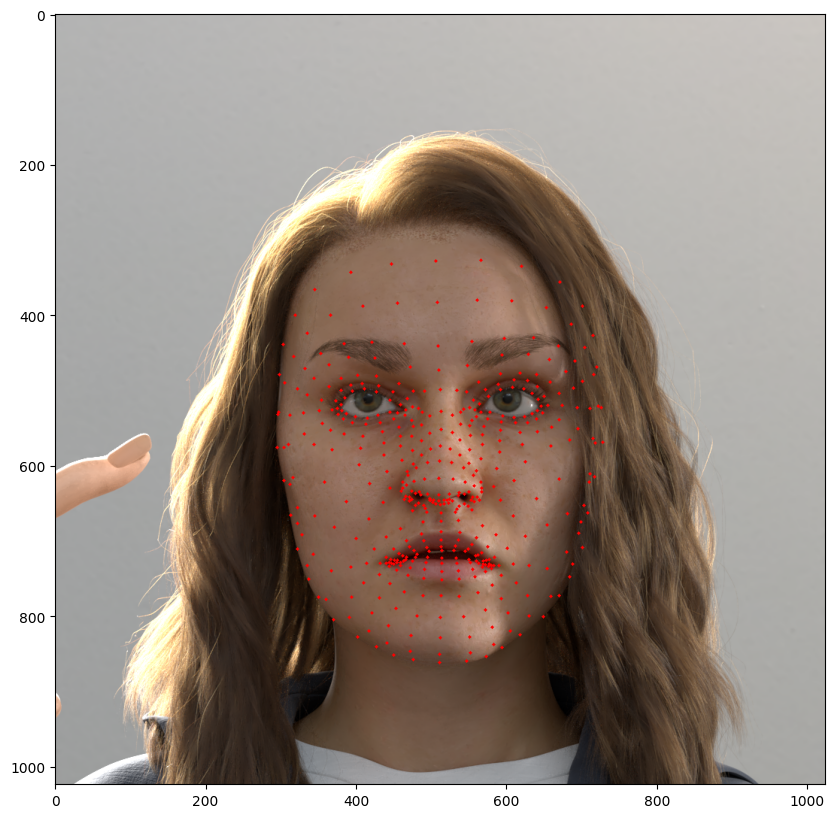

In [29]:
plt.figure(figsize=(10,10))
landmark_show(item[Modality.RGB], cam_to_screen(intrinsics, lm_dense_mediapipe))


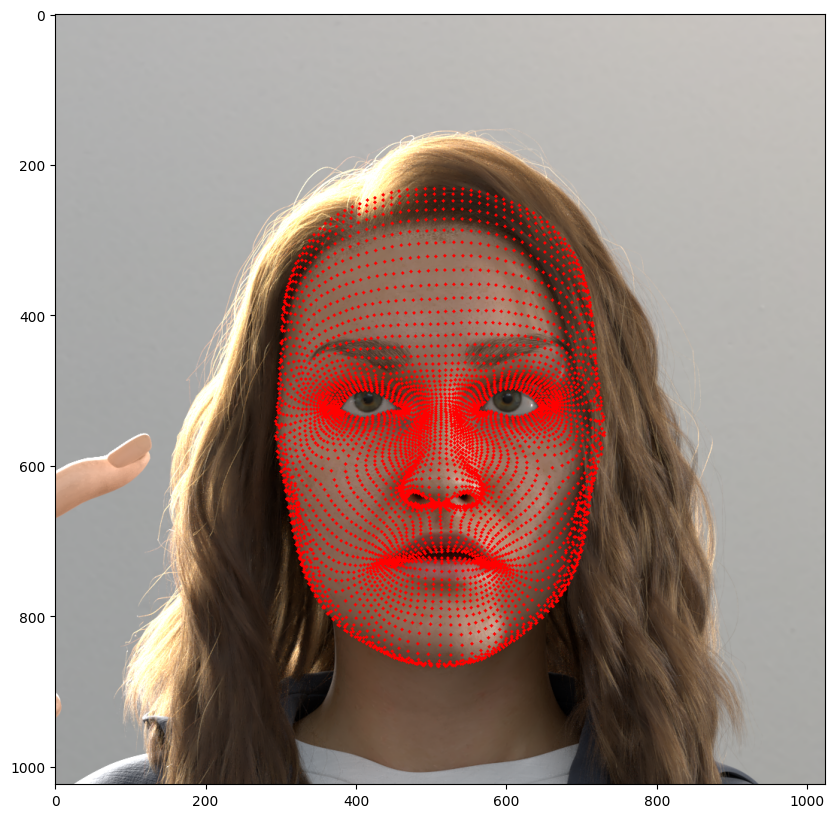

In [30]:
plt.figure(figsize=(10,10))
landmark_show(item[Modality.RGB], cam_to_screen(intrinsics, lm_dense_sai))

In [ ]:
x,y,z = lm_dense_mediapipe.transpose()
fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z, mode='markers+text', marker={"size": 2})])
fig.update_layout(scene_camera={"eye": {"x": 0., "y": 0., "z": 2},
                                "up": {"x": 0, "y": 1, "z": 0}}, title="DENSE_MEDIAPIPE")
fig.show()

In [ ]:
x,y,z = lm_dense_sai.transpose()
fig = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z, mode='markers+text', marker={"size": 2})])
fig.update_layout(scene_camera={"eye": {"x": 0., "y": 0., "z": 2},
                                "up": {"x": 0, "y": 1, "z": 0}}, title="DENSE_SAI")
fig.show()

### 3D space

In this section we will use two different cameras, align them and reconstruct 3D view of the scene.

Reinit some previouse functions if you have started from this chapter:

In [31]:
import cv2
import numpy as np
from synthesisai import SaiDataset, Modality

def opengl_to_opencv(x):
    return np.array(x) * [1, -1, -1]

def cam_to_hom_screen(intrinsics, x):
    return np.tensordot(opengl_to_opencv(x), intrinsics, axes=(-1, 1))

def from_homogeneous_2D(xs):
    xs_array = np.array(xs)
    assert (xs_array.shape[-1] == 3)

    slice_but_last = [slice(None)] * (xs_array.ndim - 1) + [slice(None, -1)]
    slice_but_last = tuple(slice_but_last)

    slice_last = [slice(None)] * (xs_array.ndim - 1) + [slice(-1, None)]
    slice_last = tuple(slice_last)
    return xs_array[slice_but_last] / xs_array[slice_last]

def cam_to_screen(intrinsics, x):
    return from_homogeneous_2D(cam_to_hom_screen(intrinsics, x))

def landmark_show(img, landmarks, radius=2, labels=True):
    l_img = np.copy(img)
    for x, y in landmarks:
        int_p = (int(x), int(y))
        cv2.circle(l_img, int_p, radius=radius, color=(255, 0, 0), thickness=cv2.FILLED)
    plt.imshow(l_img)

Load dataset:

In [32]:
data_root = "humans_api_example_dataset"
dataset = SaiDataset(
    data_root,
    modalities=[
        Modality.RGB,
        Modality.CAM_INTRINSICS,
        Modality.LANDMARKS_3D_IBUG68,
        Modality.LANDMARKS_IBUG68,
        Modality.DEPTH,
        Modality.CAM_TO_HEAD,
        Modality.CAM_TO_WORLD,
        Modality.WORLD_TO_CAM,
        Modality.LANDMARKS_3D_KINECT_V2,
        Modality.LANDMARKS_KINECT_V2,
    ]
)
dataset = dataset[45:48]

human_instance_id = "human_1"
len(dataset)

3

#### Dataset overview:

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.graph_objects as go

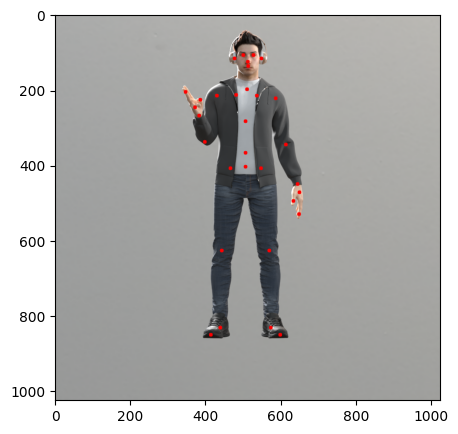

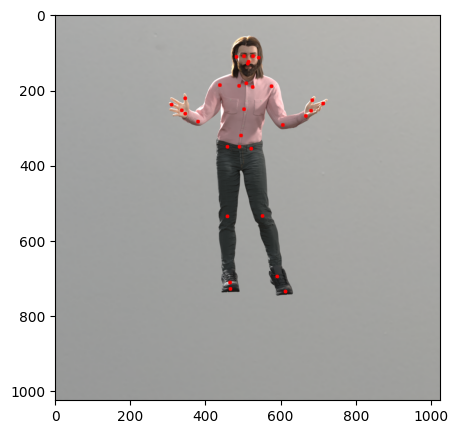

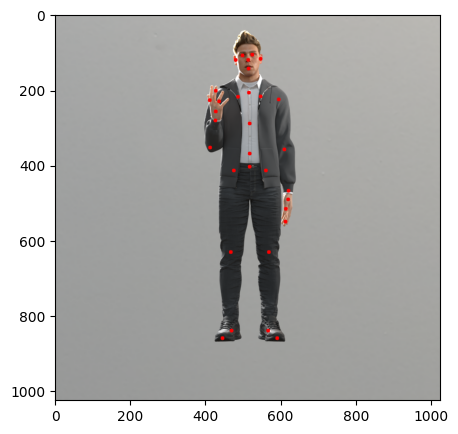

In [34]:
cameras_matrixes = []
for item_idx in range(len(dataset)):
    item = dataset[item_idx]
    intrinsics = item[Modality.CAM_INTRINSICS]
    landmarks_2D = cam_to_screen(intrinsics, np.array(list(item[Modality.LANDMARKS_3D_KINECT_V2][human_instance_id].values()), dtype=np.float64))
    plt.figure(figsize=(10,5))
    landmark_show(item[Modality.RGB], landmarks_2D, radius=5)
    plt.show()

### Lets plot 2 items in the same 3D space:

In [35]:
def get_3D_points(item, human_instance_id):
    intrinsics = item[Modality.CAM_INTRINSICS]
    rev_intrinsics = np.linalg.inv(intrinsics)
    c2w = item[Modality.CAM_TO_WORLD]

    shape = item[Modality.RGB].shape
    depth = item[Modality.DEPTH]
    color = item[Modality.RGB]
    landmarks_3D = np.array(list(item[Modality.LANDMARKS_3D_KINECT_V2][human_instance_id].values()), dtype=np.float64)
    landmarks_2D = np.array(list(item[Modality.LANDMARKS_KINECT_V2][human_instance_id].values()), dtype=np.float64)

    screen_xs, screen_ys = np.meshgrid(
        np.linspace(0, shape[1] - 1, shape[1]),
        np.linspace(0, shape[0] - 1, shape[0]))

    focal_length_p = intrinsics[0,0]
    depth_new = depth / np.sqrt(((((screen_xs - 640) ** 2 + (screen_ys - 400) ** 2) ** 0.5) / focal_length_p) ** 2 + 1)

    screen_xs = screen_xs.reshape(-1)
    screen_ys = screen_ys.reshape(-1)
    depth_new = depth_new.reshape(-1)
    color = color.reshape(-1, 3)

    xs, ys, zs = np.dot(rev_intrinsics, np.vstack([screen_xs * depth_new, screen_ys * depth_new, depth_new])) * np.array([1,-1,-1]).reshape(-1, 1)
    xs, ys, zs = np.dot(c2w, np.vstack([xs, ys, zs, np.ones_like(zs)]))[:3]

    xl, yl, zl = landmarks_3D.T
    xl, yl, zl = np.dot(c2w, np.vstack([xl, yl, zl, np.ones_like(zl)]) )[:3]
    
    return (xs, ys, zs, color), (xl, yl, zl)

In [36]:
(xs0, ys0, zs0, color0), (xl0, yl0, zl0) = get_3D_points(dataset[0], human_instance_id)
(xs1, ys1, zs1, color1), (xl1, yl1, zl1) = get_3D_points(dataset[1], human_instance_id)

In [ ]:
stride=10
fig = go.Figure(
    data=[
        go.Scatter3d(x=xs0[zs0<1][::stride], y=ys0[zs0<1][::stride], z=zs0[zs0<1][::stride],
                                   mode='markers+text', marker={"size": 1,
                                                                "color": color0[zs0<1][::stride],
                                                               }),
        go.Scatter3d(x=xs1[zs1<1][::stride], y=ys1[zs1<1][::stride], z=zs1[zs1<1][::stride],
                                   mode='markers+text', marker={"size": 1,
                                                                "color": color1[zs1<1][::stride],
                                                               }),
        go.Scatter3d(x=xl0, y=yl0, z=zl0,
                                   mode='markers+text', marker={"size": 3,
                                                                "color": np.repeat(np.array([[255,0,0]]), len(zl0), 0),
                                                               }),
        go.Scatter3d(x=xl1, y=yl1, z=zl1,
                                   mode='markers+text', marker={"size": 3,
                                                                "color": np.repeat(np.array([[0,0,255]]), len(zl1), 0),
                                                               }),
    ])
fig.update_layout(
    width=500,
    height=500,
    scene_camera={"eye": {"x": 0., "y": 0., "z": 2},
                  "up": {"x": 0, "y": 1, "z": -2}},
                  title="3D space")
fig.show()